# **Municipality Budget Planning**

In this project we seek to analyse the surplus per capita in budgeting for the Danish municipalities. By use of data from Statistics Denmark we seek to find any pattern between the budgeted and actual net expenditure for the municipalities. We further examine if population size has any influence on the municipalities estimates for expenditure.

To analyse our problem, we make use of several python packages, which we import in the code below.

In [1]:
#needed for matplotlib to function in notebook
%matplotlib inline

#import packages
import numpy as np
import pandas as pd
import pydst
from matplotlib import pyplot as plt
import scipy.stats

#import class from local file
from NokiaSnakeClient import graphwindow  

#setting default language for DST api
Dst = pydst.Dst(lang='en')

## **Data sorting**

In order to examine our topic, we retrieve data from the DST api. We get data from the tables REGK11, BUDK1 and INDAMP01.
we use REGK11 to get accounting data for all municipalities in Denmark. The data is registered at the end of the year. REGK11 covers the period 2011-2018.
BUDK1 is used to get budget data for all municipalities in Denmark. The data is registered at the beginning of the year and covers the period 2009-2019.
We use INDAMP01 to get population data to examine our problem. the population is registered 1st of January and the table covers the period 2006-2017.

When fetching data from the DST api we restrict it to only include current prices per capita, total main account and current expenditure for BUDK1 and REGK11, while the data from INDAMP01 is restricted to include all people across gender, age, etc.

In order to follow the data sorting and cleaning throughout the paper, we'll include account.head() to demonstrate the changes on the table

In [2]:
#fetching data from DST api with pydst package
account = Dst.get_data(table_id = "REGK11", variables = {"OMRÅDE": ["*"], "FUNK1": ["X"], "DRANST": ["1"], "ART": ["TOT"], "PRISENHED": ["INDL"], "Tid": ["*"]})
budget = Dst.get_data(table_id = "BUDK1", variables = {"REGI07A": ["*"], "FUNK1": ["X"], "DRANST": ["1"], "ART": ["TOT"], "PRISENHED": ["INDL"], "Tid": ["*"]})
population = Dst.get_data(table_id = "INDAMP01", variables = {"OMRÅDE": ["*"], "KØN": ["TOT"], "ALDER": ["TOT"], "PERSG": ["IALT"], "Tid": ["*"], "BNØGLE": ["PER"]})

In [3]:
account.head()

,OMRÅDE,FUNK1,DRANST,ART,PRISENHED,TID,INDHOLD
0,Hillerød,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,62180
1,Solrød,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,53166
2,Dragør,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,53794
3,Gribskov,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,61529
4,Gentofte,Total main account 0-6,1 Current expenditure,Total,"Per capita, current prices (DKK)",2012,54695


We have several columns in our data which have no use in our analysis. They are therefore dropped. Further, we rename the columns to get more appropriate names

In [4]:
#drop unneeded columns
account.drop(["FUNK1", "DRANST", "ART", "PRISENHED"], axis=1, inplace=True)
budget.drop(["FUNK1", "DRANST", "ART", "PRISENHED"], axis=1, inplace=True)
population.drop(["KØN", "ALDER", "PERSG", "BNØGLE"], axis=1, inplace=True)

#renaming columns
budget.rename(columns = {"REGI07A":"Municipality", "TID": "Year", "INDHOLD":"Budget"}, inplace = True)
account.rename(columns = {"OMRÅDE":"Municipality", "TID": "Year", "INDHOLD":"Account"}, inplace = True)
population.rename(columns = {"OMRÅDE":"Municipality", "TID": "Year", "INDHOLD":"POP"}, inplace = True)

account.head()

,Municipality,Year,Account
0,Hillerød,2012,62180
1,Solrød,2012,53166
2,Dragør,2012,53794
3,Gribskov,2012,61529
4,Gentofte,2012,54695


Our three dataframes do not share the same dimensions and cannot be merged. We have to further clean the dataframes before we can make our analysis

In [5]:
budget.info()
account.info()
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 3 columns):
Municipality    1144 non-null object
Year            1144 non-null int64
Budget          1144 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 3 columns):
Municipality    832 non-null object
Year            832 non-null int64
Account         832 non-null int64
dtypes: int64(2), object(1)
memory usage: 19.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 3 columns):
Municipality    1380 non-null object
Year            1380 non-null int64
POP             1380 non-null int64
dtypes: int64(2), object(1)
memory usage: 32.4+ KB


In order to make our dataframes comparable, we remove all entries for non-municipalities. We further restrict the time periods for our data to the period 2011-2017.

In [6]:
#dropping rows for region, province and all Denmark
for val in ["Region", "Province", "All Denmark"]:
    for dataset in [population, budget, account]:
        rowstodrop = dataset.loc[dataset["Municipality"].str.contains(val)].index
        dataset.drop(rowstodrop, axis=0, inplace=True)

#create list with time period
a = []
for i in range(2011,2018):
    a.append(str(i))

#limit data to time period a
budget = budget.loc[budget["Year"].isin(a)]
population = population.loc[population["Year"].isin(a)]
account = account.loc[account["Year"].isin(a)]

In [7]:
budget.info()
population.info()
account.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 888
Data columns (total 3 columns):
Municipality    686 non-null object
Year            686 non-null int64
Budget          686 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 1378
Data columns (total 3 columns):
Municipality    686 non-null object
Year            686 non-null int64
POP             686 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 686 entries, 0 to 831
Data columns (total 3 columns):
Municipality    686 non-null object
Year            686 non-null int64
Account         686 non-null int64
dtypes: int64(2), object(1)
memory usage: 21.4+ KB


As seen from the .info() our dataframes have the same dimensions and we are able to merge them. We do an outer merge in two stages. First, we merge people and account as the partialmerge dataframe. We then merge partialmerge with budget.

In [8]:
#merge datasets
partialmerge = pd.merge(population, account, how="outer", on=["Municipality", "Year"])
fullymerged = pd.merge(partialmerge, budget, how="outer", on=["Municipality", "Year"])
fullymerged.head()

,Municipality,Year,POP,Account,Budget
0,Holbæk,2011,69521,61203,61099
1,Faxe,2011,35277,59814,59963
2,Kalundborg,2011,49088,66668,66307
3,Ringsted,2011,32890,61444,62650
4,Slagelse,2011,77442,63393,63924


We want to compute the surplus, which we define as the difference between the budgeted and actual net expenses. We add the column named surplus to our dataframe fullymerged.

in the .head() we chose to look at Aalborg municipality to verify the accuracy of the computation

In [9]:
#creating new column
fullymerged["Surplus"] = fullymerged["Budget"]-fullymerged["Account"]

fullymerged[fullymerged["Municipality"]=="Aalborg"].head()

,Municipality,Year,POP,Account,Budget,Surplus
63,Aalborg,2011,199188,61958,62758,800
161,Aalborg,2012,201142,64535,65523,988
259,Aalborg,2013,203448,60966,61530,564
390,Aalborg,2014,205809,60002,60343,341
488,Aalborg,2015,207805,60893,60157,-736


## **Data Analysis**




To start our analysis, we look at the distribution of the surplus per capita. We compare the surplus distribution with the gaussian distribution to get further insights into the data.

Mean for Surplus: 1416.631195335277
Std. dev. for Surplus: 1626.4433776729281


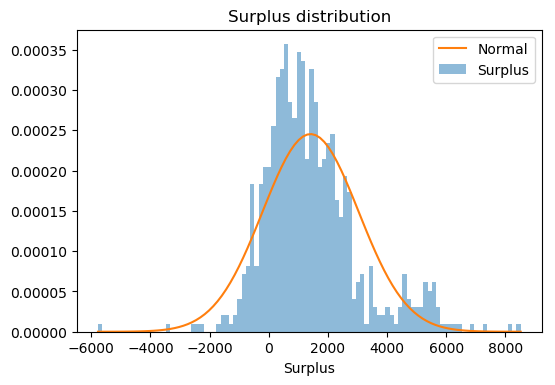

In [10]:
#define function to draw graph type
def surplusdistribution(data, title, printname):
    #calculating stats for the data set
    mean = np.mean(data["Surplus"])
    variance = np.var(data["Surplus"])
    sigma = np.sqrt(variance)
    normal = np.linspace(min(data["Surplus"]), max(data["Surplus"]), 100)
    
    #creating a figure and adding subplots
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    ax.hist(data["Surplus"], density=True, bins = 100, alpha = 0.5, label = "Surplus")
    ax.plot(normal, scipy.stats.norm.pdf(normal, mean, sigma), label = "Normal")
    ax.set_xlabel("Surplus")
    ax.set_title(title)
    ax.legend()
    
    print("Mean for " + printname + ": " + str(mean))
    print("Std. dev. for " + printname + ": " + str(sigma))

#calling function 
surplusdistribution(fullymerged,"Surplus distribution", "Surplus")


From the stats and the graph, we see a clear tendency for municipalities to overestimate their expenditure for the year. The distribution has a mean of 1416 dkk per capita and seems to be skewed to the right, which further indicates the tendency to overestimate expenditure. 

We further want to examine a possible correlation in municipalities' surplus and the population of the municipality.

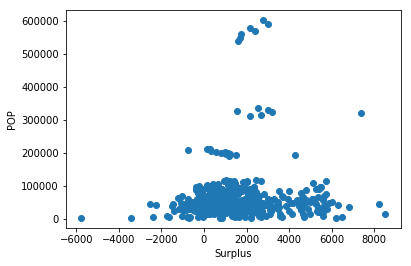

In [11]:
#create scatter plot function
def scatterplot(data, x, y,title=""):
    plt.scatter(data[x], data[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.show()

#calling scatterplot function for our data
scatterplot(fullymerged, "Surplus", "POP")

The scatter plot shows no clear correlation between population and surplus per capita in Danish municipalities. The mean for municipalities with a population above 150000 seems to be higher, while the standard deviation seems to be lower. To further examine this, we will split the data in a high population and low population dataset

#### High vs. low population

The dataset fullymerged is split into a high and low population dataset. We define any municipality with a population over 150000 people as a high population municipality. We create a surplus distribution for both datasets

Mean for POP > 150k: 1838.8214285714287
Std. dev. for POP > 150k: 1515.0229855298146
Mean for POP < 150k: 1398.6656534954407
Std. dev. for POP < 150k: 1628.589892252984


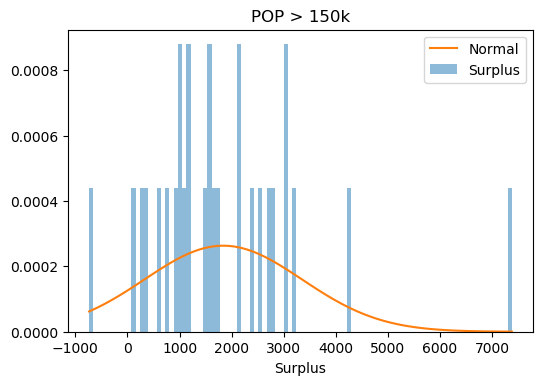

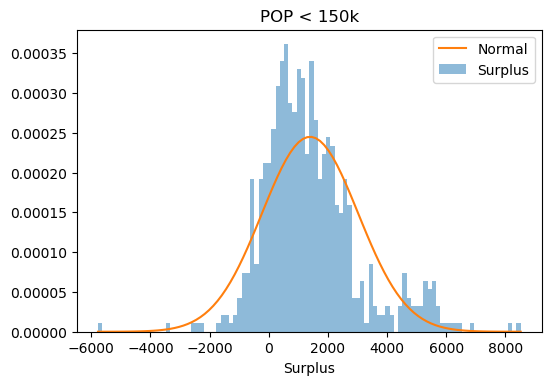

In [12]:
#splitting dataset in high and low POP
above150k = fullymerged.loc[fullymerged["POP"]>150000]
below150k = fullymerged.loc[fullymerged["POP"]<=150000]
above150k.name = "POP > 150k"
below150k.name = "POP < 150k"

#creating graphs with graph function 
for data in [above150k, below150k]:
    surplusdistribution(data,data.name,data.name)

As suspected from the scatter plot, high population municipalities have a higher mean and lower standard deviation compared to low population municipalities. The sample for POP>150k is rather low, and no apparent distribution takes form in the figure. The distribution for low population municipalities is nearly identical to the combined surplus per capita. The mean is a bit lower while the standard deviation is a bit higher.
It seems municipalities with a low population on average is better at predicting their net expenditure per capita than their high population counterpart. The higher mean for high population municipalities indicates a higher inefficiency in adjusting their expectations to expenditure.

we further create to scatterplots to examine for any further correlation between population and surplus per capita

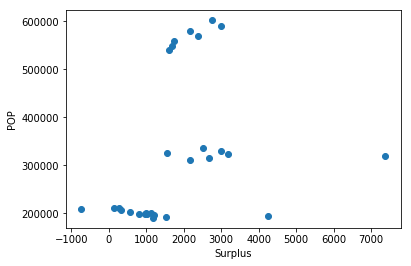

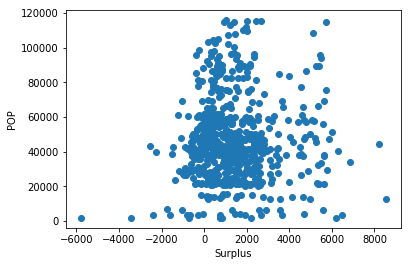

In [13]:
#creating graphs with graph function 
for data in [above150k, below150k]:
    scatterplot(data, "Surplus", "POP")

We find no correlation between population and surplus per capita in the two datasets. The municipalities are randomly spread with a tendency for surplus as explained in the distribution figures.

#### Development in municipalities

By use of the graphwindow class from the NokiaSnakeClient application we are able to examine the development of population and surplus in the respective municipalities over the period 2011-2017. The class opens a separate graph window when run.

In [14]:
#create instance of graphwindow class, set size of window, run with mainloop()
app = graphwindow(data=fullymerged, x="Year",y="Surplus",y2="POP",graphnames="Municipality")
app.geometry("1280x720")
app.mainloop()

No consistent pattern can be found between population growth and surplus per capita across municipalities. municipality of Copenhagen have a somewhat consistent surplus while having population growth, whereas Aarhus have larger deviations in surplus while also having a surplus.

We encourage the reader to use the graphwindow to explore the different municipalities

## Conclusion

In this project we find a tendency for Danish municipalities to overestimate net expenditures per capita. With a mean of 1416 and a standard deviation of 1626 most municipalities have a positive surplus. We find no direct correlation between population and surplus per capita. There seems to be some differences between high population and low population municipalities, however the small sample size for high population municipalities makes it difficult to draw any conclusions.